# Workshop SL02: Regression

## Agenda
- Feature Engineering
- Common regression models

For this workshop we are gonna work with a new dataset (download it [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) or from google drive) and try out different regression models. This dataset is actually an ongoing competition on Kaggle, where we need to predict house sales prices with feature engineering techniques and advanced regression techniques. If you go to leaderboard, you can see some crazy good accuracy, but don't be intimidated by that because we're just starting!

## Exercise
- create new features to boost performance
- try out different regression model

### Prep work

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

#### Basis

In [86]:
# read data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# target dataframe 
Y_train = df_train['SalePrice']
Y_train = pd.DataFrame(Y_train)

# encoding strings
obj_df = df_train.select_dtypes(include=['object']).copy()
int_df = df_train.select_dtypes(include=['int64']).copy()
float_df = df_train.select_dtypes(include=['float64']).copy()
for column in obj_df.head(0):
    obj_df[column] = obj_df[column].astype('category')
    obj_df[column] = obj_df[column].cat.codes
X_train = pd.concat([obj_df,int_df,float_df],axis=1, sort=False) 

# filling na
X_train.fillna(value=-1,inplace=True)

#### Feature Engineering 
Feature engineering is also an important technique in obtaining high-quality data. There are many creative ways to create new features, [here's](https://towardsdatascience.com/automated-feature-engineering-in-python-99baf11cc219) a really good article on how.

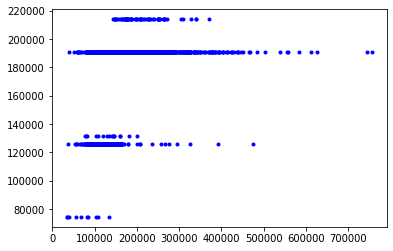

In [87]:
# remember, creative feature engineering can boost performance remarkably
# so try thinking of some new feature! 
# simple example: mean of house price for each zone
mean = X_train.groupby(['MSZoning'])['SalePrice'].mean()
def zone_mean(zone):
    return mean[zone]
X_train['ZoneMean'] = X_train['MSZoning'].apply(zone_mean)
plt.plot(Y_train,X_train['ZoneMean'],'.b')

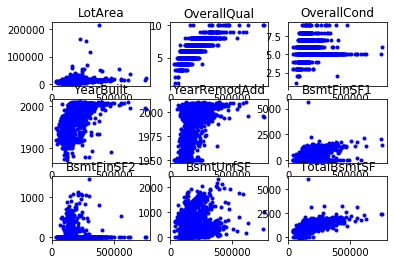

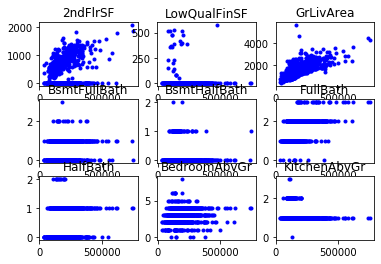

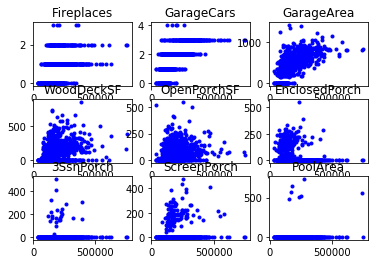

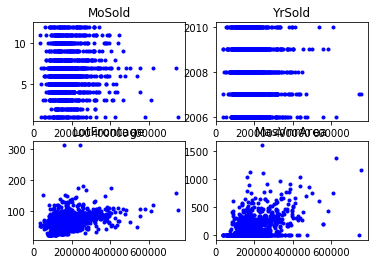

In [88]:
# some visualization to help you with designing features
num_df = pd.concat([int_df,float_df],axis=1, sort=False) 
list = ['SalePrice','Id']
num_df = num_df.drop(list, axis=1)
for j in range(1,4):
    plt.figure(j)
    for i in range(10*j-9,10*j):
        plt.subplot(3,3,i-(10*j-10))
        plt.plot(df_train['SalePrice'],num_df.iloc[:,i],'.b')
        plt.title(num_df.columns[i])

plt.figure(4)
for i in range(31,35):
    plt.subplot(2,2,i-30)
    plt.plot(df_train['SalePrice'],num_df.iloc[:,i],'.b')
    plt.title(num_df.columns[i])

In [89]:
# dropping should be the final step in prepping data 
# dropping the irrelevant data for training
list = ['SalePrice','Id']
X_train = X_train.drop(list, axis=1)
# spliting test/train data into 80:20
from sklearn.model_selection import train_test_split
train_size = int(0.8*X_train.shape[0])
test_size = X_train.shape[0]-train_size
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train, train_size=train_size, test_size=test_size, random_state=4)

In [90]:
# this cell is optional: run this if you don't want to read the future warning messages
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
# this is to stop the format warning
Y_train = np.array(Y_train).ravel()
Y_test = np.array(Y_test).ravel()

### Model Training
List of regression models:
- [Generalized Linear Models](https://scikit-learn.org/stable/modules/linear_model.html)
- [Kernel Ridge Regression](https://scikit-learn.org/stable/modules/kernel_ridge.html)
- [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html)
- [Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
- [Gaussian Processes](https://scikit-learn.org/stable/modules/gaussian_process.html)
- [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
- [Trees](https://scikit-learn.org/stable/modules/tree.html)
- [Ensemble Methods](https://scikit-learn.org/stable/modules/ensemble.html) 
- Other non-linear models (Spline, Polynomial Regression, General Additive Model)
- Neural Network (more about this in later workshops) 


Apart from single output regression, there is a more difficult regression problem when we need to return multiple outputs. In that case we nned to use `MultiOutputRegressor` with any regressor. More details [here](https://scikit-learn.org/stable/modules/multiclass.html#multioutput-regression). 

Since we have already covered the brief introduction to each algorithm in the classification workshop, we won't be repeating here again. 

#### 1) GLM

In [91]:
from sklearn import linear_model
#training model
ols = linear_model.LinearRegression()
ols.fit(X_train,Y_train)
# predict on test data
Y_ols = ols.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_ols))
print(rmse);print(ols.score(X_train,Y_train))

27996.364640915996
0.8674022237414821


Now we have a over-fitting problem because the default regression model fit very well on training data but not on test data. Perhaps we could throw in a few regulization methods? 

In [93]:
#training model
ridge = linear_model.RidgeCV() 
# ols + l2-norm penalty on model complexity, complexity parameter is chosen by CV
ridge.fit(X_train,Y_train)
# predict on test data
Y_ridge = ridge.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_ridge))
print(rmse);print(ridge.score(X_train,Y_train));print(ridge.alpha_)

27728.266281195545
0.866242719159842
1.0


In [94]:
#training model
lasso = linear_model.LassoCV() 
# ols + l1-norm penalty on model complexity, complexity parameter (alpha) is chosen by CV
lasso.fit(X_train,Y_train)
# predict on test data
Y_lasso = lasso.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_lasso))
print('rmse is '+str(rmse)+' and alpha used is '+str(lasso.alpha_))

rmse is 38946.935692158346 and alpha used is 730466.9469244162


The following is to show how the penalty on model complexity shrink the linear model. As we can see, from left to right of the graph, the larger the penalty parameter (alpha), the less features. Hence, the less important features will be removed in early stage (small alpha) whereas the more important features will remain until alpha is too large.  

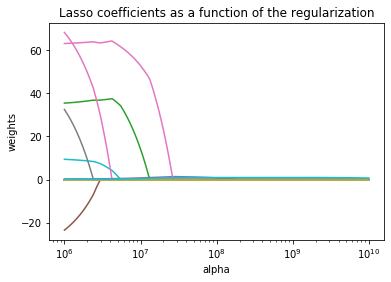

In [98]:
# creating a grid of alphas
n_alphas = 200
alphas = np.logspace(6, 10, n_alphas) #alpha ranging from 10^6 to 10^10
# fitting lasso with different alphas
coefs = []
feat = []
for a in alphas:
    lasso = linear_model.Lasso(alpha=a, fit_intercept=False)
    lasso.fit(X_train,Y_train)
    coefs.append(lasso.coef_)
    feat.append(X_train.columns[lasso.coef_ != 0])
# plotting alphas against coefficients of features
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

Let's zone in and see closer at the tail. 

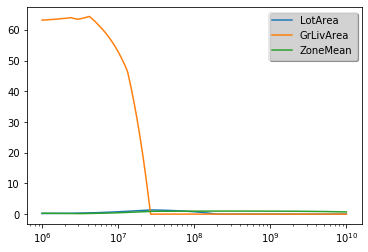

In [99]:
# making a transpose of coefs numpy array, 80 by 200
coefs_t = np.transpose(coefs) 
# zone into the tail and see closer 
large_alpha = 10**7.3 # the larger alpha, the closer to tha tail
lasso_tail = linear_model.Lasso(alpha=large_alpha, fit_intercept=False).fit(X_train,Y_train)
coefs_s = coefs_t[lasso_tail.coef_ != 0] # select the important features
feats = X_train.columns[lasso_tail.coef_ != 0]
ax = plt.gca()
for n in range(np.shape(coefs_s)[0]):
    ax.plot(alphas, coefs_s[n],label=feats[n]) #label
ax.set_xscale('log')
leg = plt.legend(shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)


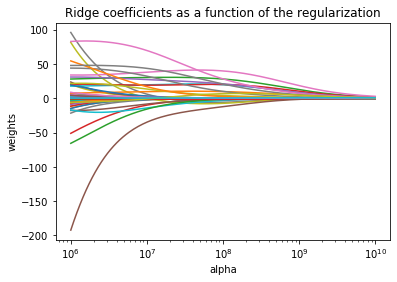

In [101]:
# creating a grid of alphas
n_alphas = 200
alphas = np.logspace(6, 10, n_alphas) #alpha ranging from 10^6 to 10^10
# fitting lasso with different alphas
coefs = []
feat = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train,Y_train)
    coefs.append(ridge.coef_)
    feat.append(X_train.columns[ridge.coef_ != 0])
# plotting alphas against coefficients of features
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [11]:
#training model
en = linear_model.ElasticNet() 
en.fit(X_train,Y_train)
# predict on test data
Y_en= en.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_en))
print(rmse)

27203.341152057314


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [11]:
#training model
en = linear_model.ElasticNet() 
en.fit(X_train,Y_train)
# predict on test data
Y_en= en.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_en))
print(rmse)

27203.341152057314


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [12]:
#training model
lassolars = linear_model.LassoLarsCV() 
lassolars.fit(X_train,Y_train)
# predict on test data
Y_lassolars= lassolars.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_lassolars))
print(rmse)

27540.64299629788


In [13]:
#training model
omp = linear_model.OrthogonalMatchingPursuitCV() 
omp.fit(X_train,Y_train)
# predict on test data
Y_omp= omp.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_omp))
print(rmse)

31624.63901733662


In [14]:
#training model
br = linear_model.BayesianRidge() 
br.fit(X_train,Y_train)
# predict on test data
Y_br= br.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_br))
print(rmse)

26985.945150272317


In [15]:
#training model
par = linear_model.PassiveAggressiveRegressor(loss='squared_epsilon_insensitive') 
par.fit(X_train,Y_train)
# predict on test data
Y_par= par.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_par))
print(rmse)

70070.54159400384


In [16]:
#training model
ransac = linear_model.RANSACRegressor() # robust regressor to deal with outliners
ransac.fit(X_train,Y_train)
# predict on test data
Y_ransac= ransac.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_ransac))
print(rmse)

28415.021573060767


#### 2) Kernel Ridge Regression

In [17]:
from sklearn.kernel_ridge import KernelRidge
#training model
kr = KernelRidge() 
kr.fit(X_train,Y_train)
# predict on test data
Y_kr= kr.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_kr))
print(rmse)

27689.58509136795


#### 3) SVM

In [18]:
from sklearn.svm import SVR
#training model
svr = SVR() 
svr.fit(X_train,Y_train)
# predict on test data
Y_svr= svr.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_svr))
print(rmse)

76337.66070112138


#### 4) Nearest Neighbors

In [19]:
from sklearn.neighbors import RadiusNeighborsRegressor, KNeighborsRegressor
#training model
rn = KNeighborsRegressor() 
rn.fit(X_train,Y_train)
# predict on test data
Y_rn= rn.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_rn))
print(rmse)

46262.58596878008


#### 5) Gaussian Processes

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor
#training model
gp = GaussianProcessRegressor() 
gp.fit(X_train,Y_train)
# predict on test data
Y_gp= gp.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_gp))
print(rmse)

195363.526286789


#### 7) Trees

In [21]:
from sklearn import tree
#training model
dt = tree.DecisionTreeRegressor()
dt.fit(X_train,Y_train)
# predict on test data
Y_dt= dt.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_dt))
print(rmse)

37144.70253076898


#### 8) Ensemble Methods

In [22]:
from sklearn.ensemble import BaggingRegressor
bag = BaggingRegressor() # default estimator is tree
bag.fit(X_train,Y_train)
# predict on test data
Y_bag = bag.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_bag))
print(rmse)

26416.935903496684


In [23]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train,Y_train)
# predict on test data
Y_rf = rf.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_rf))
print(rmse)

26075.472311031226


In [24]:
from sklearn.ensemble import ExtraTreesRegressor
et = ExtraTreesRegressor()
et.fit(X_train,Y_train)
# predict on test data
Y_et = et.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_et))
print(rmse)

27878.364737014876


In [25]:
from sklearn.ensemble import AdaBoostRegressor
ab = AdaBoostRegressor() # default estimator is tree
ab.fit(X_train,Y_train)
# predict on test data
Y_ab = ab.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_ab))
print(rmse)

33300.44722232451


In [26]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor() # default estimator is tree
gb.fit(X_train,Y_train)
# predict on test data
Y_gb = gb.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_gb))
print(rmse)

23025.851933497175


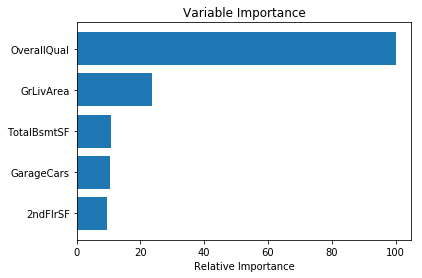

In [29]:
# Plot feature importance
feature_importance = gb.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[75:80] # 5 largest importance
pos = np.arange(sorted_idx.shape[0]) + 1

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

23025.851933497175


Text(0, 0.5, 'Deviance')

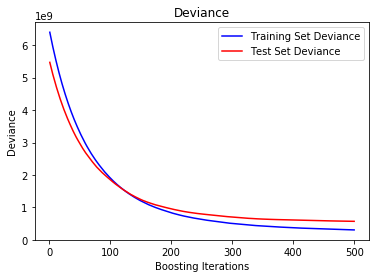

In [30]:
# Plot training deviance
# compute test set deviance
params = {'n_estimators': 500, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
gb = GradientBoostingRegressor(**params)
gb.fit(X_train,Y_train)
rmse = math.sqrt(mean_squared_error(Y_test, Y_gb))
print(rmse)
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, Y_gb in enumerate(gb.staged_predict(X_test)):
    test_score[i] = gb.loss_(Y_test, Y_gb)


plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gb.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

#### 9) Other non-linear models
Other non-linear models include polynomial regression, splines, GAM etc. Normally the most effective way is to combine these models together through addition, AKA General Additive Model (GAM):

$$ prediction = intercept + f_1(feature_1) + f_2(feature_2) + ... + f_p(feature_p),$$

where $f_1,f_2,...f_p$ are different basic functions, which could be anything such as polynomial, spline, log etc. The fitting of $f_i$'s simultaneously is difficult and it's usually done by back-fitting. 

As we can see, for GAM we need to assign different functions to different features, so it's probably more effective when we have less features. More details [here](https://lagunita.stanford.edu/c4x/HumanitiesScience/StatLearning/asset/nonlinear.pdf). 

In our case, spline is probably not that useful. Spline is probably more useful when we are studying pattern and such. For example, when we're predicting the next location of an moving object, or predicting mortality given age. But again, we're not experts in this field. If you have any idea and insight please do share. [Here](https://docs.scipy.org/doc/scipy/reference/interpolate.html) is a library for spline.

In [39]:
# polynomial regression 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
pl = Pipeline([('poly', PolynomialFeatures(degree=3,interaction_only=True)), # transform x to 1,x,x**@,x**3
                  ('linear', linear_model.LinearRegression(fit_intercept=False))])
pl.fit(X_train,Y_train)
# predict on test data
Y_pl = pl.predict(X_test)
# accuracy 
rmse = math.sqrt(mean_squared_error(Y_test, Y_pl))
print(rmse)

262331.54171930667


As you cann see, all the models have over-fitting problem. This is because the dataset is way too small. We can fix that by increasing the data size using data augmentation methods like bootstraping, or Monte Carlo simulations.

That's the end of supervised learning! Now we know many of you are very eager to learn unsupervised learning, but before we march into that, we first need to learn deep learning as this is the biggest guy in unsupervised learning. Hope to see you all in the next workshop for deep learning! 